In [1]:
import os
import h5py
import shutil
import zipfile
import requests
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sklearn.utils import shuffle
from keras.preprocessing import image
from keras import models,layers,applications


Using TensorFlow backend.


In [2]:
url_train = 'https://storage.googleapis.com/kaggle-competitions-data/kaggle/5441/train.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1514350214&Signature=PKJ74GFjI4VCjTMCET89zhdah%2FD45XlYZ1epoVoCVoNQIHQEtxBT%2ByQQeISxXsklEToMx3rQp50g293VreoPe7ZdZxJ1%2FTchqD27jvRVtsMfA75uLMpAxuACZ4J09XNUi8x1WHVtJnZc37mpA%2F8uX5BjMuo4M7HM0Mj0%2BFmrZmiqW8IunjhRDMIrr4LWmW31W29qTUmJ2qhrLjeImLuamwAlBVzX3oYxEYl735pxNfh%2B5pCA4eQaHf8KqutrpwGUkL%2FZc3oyb%2FZt5zZ1pMVQP%2BJje6oSsqX8GOuDbBTfhn30uD17mdEkT%2B8kS1xo2iI8kZVYwoD4TlRRy7NUiQqNNA%3D%3D'
url_test = 'https://storage.googleapis.com/kaggle-competitions-data/kaggle/5441/test.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1514350212&Signature=qA70H0ET0rHWEpw2%2Bm5n4Uz5Gt0d%2FCZTxFYqdiTVnIry8Xz2KBXbWsww%2FTaQmy5Ugdw7aBGOMYuXUVggaWgpg%2BLC5GppDHjezzAN2Jq9P%2FJc%2Fes4G2qyv1VcVv0Qs2hcJt9xczg5Q%2FF4TNJT7tJuP8puKqWNqTjgk9mjYv6MNKAOXEyiRFvuVQMLdlRn27mpvr0j1R3CvpGshfJivNqv1Vlu0cWzXtQcBxhSzfRildSLkeS4JnIOqLhhguVEchTO7wAIBftH8CFtejadpzFOXp1t1x4uhBQSuXrdJ9jHDoKh4j3YoTz96cze5RCUl27gXNVDA9tbivIWUQoM2uoCYg%3D%3D'

train_path = "train.zip"
test_path = "test.zip"

def Download_data(url,path):
    r = requests.get(url) 
    with open(path, "wb") as code:
         code.write(r.content)

#解压代码
def Un_zip(file_name):  
    """unzip zip file"""  
    zip_file = zipfile.ZipFile(file_name)  
    for names in zip_file.namelist():  
        zip_file.extract(names)  
    zip_file.close() 

Download_data(url_train,train_path)
Download_data(url_test,test_path)
print("下载完成！")

Un_zip(train_path)
Un_zip(test_path)
print("解压完成！")

下载完成！
解压完成！


In [3]:
train_filenames = os.listdir('train')
test_filenames = os.listdir('test')
train_cat = filter(lambda x:x[:3] == 'cat', train_filenames)
train_dog = filter(lambda x:x[:3] == 'dog', train_filenames)

print "捕获"+str(len(train_cat))+"只猫咪！！！"
print "捕获"+str(len(train_dog))+"只狗狗！！！"

def create_mkdir(dirname):
    if os.path.exists(dirname):
        shutil.rmtree(dirname)
    os.mkdir(dirname)

def file_move(data,old_dir,new_dir):
    for filename in data:
        shutil.move(old_dir+filename, new_dir+filename)   

cat_path = 'train2/cat/'
dog_path = 'train2/dog/'

create_mkdir('train2')
os.mkdir(cat_path)
os.mkdir(dog_path)

create_mkdir('test2')
os.mkdir('test2/test')

file_move(train_cat,'train/',cat_path)
file_move(train_dog,'train/',dog_path)
file_move(test_filenames,'test/','test2/test/') 
    
shutil.rmtree("test")
shutil.rmtree("train")
print("分类完成！")

捕获12500只猫咪！！！
捕获12500只狗狗！！！
分类完成！


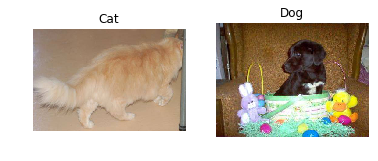

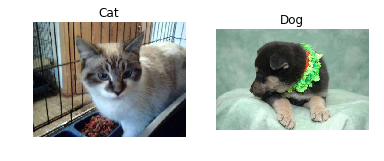

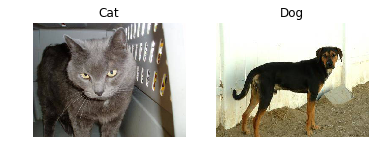

In [2]:
#显示猫和狗的图像
cat_path = 'train2/cat/'
dog_path = 'train2/dog/'
file_cat = os.listdir(cat_path)
files_dog = os.listdir(dog_path)
for i in range(3):
    image_cat = mpimg.imread(cat_path+file_cat[np.random.randint(0,12500)])
    image_dog = mpimg.imread(dog_path+files_dog[np.random.randint(0,12500)])

    plt.subplot(1,2,1)
    plt.title('Cat')
    plt.imshow(image_cat)
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.title('Dog')
    plt.imshow(image_dog)
    plt.axis('off')
    plt.show()

In [8]:
input_tensor = layers.Input((299, 299, 3))
x = input_tensor
x = layers.Lambda(applications.inception_v3.preprocess_input)(x)

base_model = applications.InceptionV3(input_tensor=x, weights='imagenet', include_top=False)
model = models.Model(base_model.input, layers.GlobalAveragePooling2D()(base_model.output))

generator = image.ImageDataGenerator()
train_generator = generator.flow_from_directory("train2", (299,299), shuffle=False, batch_size=16)
test_generator = generator.flow_from_directory("test2", (299,299), shuffle=False, batch_size=16, class_mode=None)

train = model.predict_generator(train_generator, train_generator.nb_sample)
test = model.predict_generator(test_generator, test_generator.nb_sample)
with h5py.File("InceptionV3.h5") as h:
    h.create_dataset("train", data=train)
    h.create_dataset("test", data=test)
    h.create_dataset("label", data=train_generator.classes)

Found 25000 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.


In [23]:
def write_gap(MODEL, image_size, lambda_func=None):
    width = image_size[0]
    height = image_size[1]
    input_tensor = layers.Input((height, width, 3))
    x = input_tensor
    if lambda_func:
        x = layers.Lambda(lambda_func)(x)

    base_model = MODEL(input_tensor=x, weights='imagenet', include_top=False)
    model = models.Model(base_model.input, layers.GlobalAveragePooling2D()(base_model.output))

    gen = image.ImageDataGenerator()
    train_generator = gen.flow_from_directory("train2", image_size, shuffle=False, 
                                              batch_size=16)
    test_generator = gen.flow_from_directory("test2", image_size, shuffle=False, 
                                             batch_size=16, class_mode=None)

    train = model.predict_generator(train_generator, train_generator.nb_sample)
    test = model.predict_generator(test_generator, test_generator.nb_sample)
    with h5py.File("gap_%s.h5"%MODEL.func_name) as h:
        h.create_dataset("train", data=train)
        h.create_dataset("test", data=test)
        h.create_dataset("label", data=train_generator.classes)

write_gap(applications.ResNet50, (224, 224))
write_gap(applications.InceptionV3, (299, 299), applications.inception_v3.preprocess_input)
write_gap(applications.Xception, (299, 299), applications.xception.preprocess_input)

Found 25000 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.
Found 25000 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.
Found 25000 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.


In [9]:
X_train = []
X_test = []

for filename in ["InceptionV3.h5"]:
    with h5py.File(filename, 'r') as h:
        X_train.append(np.array(h['train']))
        X_test.append(np.array(h['test']))
        y_train = np.array(h['label'])

X_train = np.concatenate(X_train, axis=1)
X_test = np.concatenate(X_test, axis=1)

X_train, y_train = shuffle(X_train, y_train)

In [2]:
input_tensor = layers.Input((299, 299, 3))
x = input_tensor
x = layers.Lambda(applications.inception_v3.preprocess_input)(x)

base_model = applications.InceptionV3(input_tensor=x, weights='imagenet', include_top=False)
model = models.Model(base_model.input, layers.GlobalAveragePooling2D()(base_model.output))

generator = image.ImageDataGenerator()
train_generator = generator.flow_from_directory("train2", (299,299), shuffle=False, 
                                          batch_size=16)
test_generator = generator.flow_from_directory("test2", (299,299), shuffle=False, 
                                         batch_size=16, class_mode=None)

X_train = model.predict_generator(train_generator, train_generator.nb_sample)
X_test = model.predict_generator(test_generator, test_generator.nb_sample)
y_train=train_generator.classes

X_train, y_train = shuffle(X_train, y_train)

Found 25000 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.


In [3]:
print X_train.shape[1:]

(2048,)


In [4]:
input_tensor = layers.Input(X_train.shape[1:])
x = layers.Dropout(0.5)(input_tensor)
x = layers.Dense(1, activation='sigmoid')(x)
model = models.Model(input_tensor, x)

model.compile(optimizer='adadelta',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [5]:
model.fit(X_train, y_train, batch_size=128, nb_epoch=20, validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/20
20000/20000 [==============================] - 0s - loss: 0.1958 - acc: 0.9301 - val_loss: 0.0555 - val_acc: 0.9884